# ДЗ6

Датасет: **MovieLens** от GroupLens — это логи взаимодействия пользователей с сервисом рекомендаций фильмов (оценки фильмов во времени).
- Используется `ratings.csv` (поля: `userId`, `movieId`, `rating`, `timestamp`).

Источник: GroupLens MovieLens Datasets: https://grouplens.org/datasets/movielens/


**0. Импорт библиотек и настройки**


In [14]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import bootstrap

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)


**1. Загрузка данных**
- Скачиваем MovieLens.
- Читаем `ratings.csv` напрямую из zip.


In [15]:
import io, zipfile, requests
import pandas as pd

MOVIELENS_URL = "https://files.grouplens.org/datasets/movielens/ml-10m.zip"

resp = requests.get(MOVIELENS_URL, stream=True)
resp.raise_for_status()

z = zipfile.ZipFile(io.BytesIO(resp.content))
names = z.namelist()

# 1) пробуем csv (25m/20m)
csv_candidates = [p for p in names if p.endswith("/ratings.csv")]

if csv_candidates:
    ratings_path = csv_candidates[0]
    with z.open(ratings_path) as f:
        ratings = pd.read_csv(
            f,
            dtype={"userId":"int32","movieId":"int32","rating":"float32","timestamp":"int64"},
        )

else:
    # 2) fallback для 10m: ratings.dat (разделитель ::)
    dat_candidates = [p for p in names if p.endswith("/ratings.dat")]
    if not dat_candidates:
        raise FileNotFoundError("Не нашёл ratings.csv или ratings.dat внутри архива")

    ratings_path = dat_candidates[0]
    with z.open(ratings_path) as f:
        ratings = pd.read_csv(
            f,
            sep="::",
            engine="python",
            header=None,
            names=["userId","movieId","rating","timestamp"],
            dtype={"userId":"int32","movieId":"int32","rating":"float32","timestamp":"int64"},
        )

ratings.head(), ratings.shape
ratings = ratings.sample(n=1_000_000, random_state=42).reset_index(drop=True)
ratings.shape

(1000000, 4)

**2. Подготовка данных и сегментация аудитории**
Сегментируем пользователей по **интенсивности использования** сервиса: число взаимодействий (кол-во оценок).
- `Light` — мало событий
- `Medium` — средне
- `Heavy` — много

Также посчитаем пользовательские метрики (уровень пользователя), чтобы сравнивать сегменты тестами.


In [17]:
ratings = ratings[["userId","movieId","rating","timestamp"]].copy()

user = ratings.groupby("userId", sort=False).agg(
    n_events=("movieId","size"),
    mean_rating=("rating","mean"),
    median_rating=("rating","median"),
    share_high=("rating", lambda x: (x >= 4.0).mean()),
    unique_movies=("movieId","nunique"),
    first_ts=("timestamp","min"),
    last_ts=("timestamp","max"),
).reset_index()

# В datetime переводим только два столбца в user-таблице
user["first_dt"] = pd.to_datetime(user["first_ts"], unit="s")
user["last_dt"]  = pd.to_datetime(user["last_ts"], unit="s")
user["active_days"] = (user["last_ts"] - user["first_ts"]) / 86400.0

In [18]:
# сегментация по tertiles числа событий
q1, q2 = user["n_events"].quantile([1/3, 2/3]).to_list()

def segment(n):
    if n <= q1:
        return "Light"
    elif n <= q2:
        return "Medium"
    return "Heavy"

user["segment"] = user["n_events"].apply(segment)

user["segment"].value_counts()


,count
segment,
Light,27570
Heavy,21986
Medium,18985


Выберем 3–4 метрики, по которым будем тестировать различия между сегментами:
- `mean_rating` — средняя оценка пользователя
- `median_rating` — медианная оценка пользователя
- `share_high` — доля оценок ≥ 4
- `unique_movies` — разнообразие (сколько уникальных фильмов оценил)


In [19]:
metrics = ["mean_rating", "median_rating", "share_high", "unique_movies"]
user.groupby("segment")[metrics + ["n_events"]].agg(["count","mean","std","median"]).round(4)


mean_rating                         median_rating                        share_high                         unique_movies  \
              count    mean     std  median         count    mean     std median      count    mean     std  median         count   
segment                                                                                                                             
Heavy         21986  3.5501  0.4522  3.5645         21986  3.6430  0.5675    4.0      21986  0.5185  0.2041  0.5208         21986   
Light         27570  3.6361  0.7733  3.6667         27570  3.6738  0.8562    4.0      27570  0.5555  0.3482  0.5000         27570   
Medium        18985  3.6462  0.5277  3.6667         18985  3.7223  0.6630    4.0      18985  0.5605  0.2384  0.5714         18985   

                                 n_events                           
            mean      std median    count     mean      std median  
segment                                                             
Heavy    34.3653  30.3881   24.0    21986  34.3653  30.3881   24.0  
Light     3.0807   1.3226    3.0    27570   3.0807   1.3226    3.0  
Medium    8.4018   1.9633    8.0    18985   8.4018   1.9633    8.0

**3. Попарные сравнения сегментов: t-тест Стьюдента и Манна–Уитни**
Делаем сравнения для каждой метрики между парами сегментов:
- Light vs Medium
- Light vs Heavy
- Medium vs Heavy



In [20]:
from itertools import combinations

pairs = list(combinations(["Light","Medium","Heavy"], 2))

def run_pair_tests(df, metric, a, b):
    x = df.loc[df["segment"]==a, metric].dropna().to_numpy()
    y = df.loc[df["segment"]==b, metric].dropna().to_numpy()

    # Welch t-test (по умолчанию более устойчив)
    t_welch = stats.ttest_ind(x, y, equal_var=False)
    # "Классический" t-test (equal variances)
    t_student = stats.ttest_ind(x, y, equal_var=True)
    # Mann–Whitney (для больших объемов используем asymptotic)
    mw = stats.mannwhitneyu(x, y, alternative="two-sided", method="asymptotic")

    return {
        "metric": metric,
        "pair": f"{a} vs {b}",
        "n_a": len(x),
        "n_b": len(y),
        "mean_a": float(np.mean(x)),
        "mean_b": float(np.mean(y)),
        "t_student_p": float(t_student.pvalue),
        "t_welch_p": float(t_welch.pvalue),
        "mw_p": float(mw.pvalue),
    }

rows = []
for m in metrics:
    for a,b in pairs:
        rows.append(run_pair_tests(user, m, a, b))

tests_pairwise = pd.DataFrame(rows).sort_values(["metric","pair"])
tests_pairwise


,metric,pair,n_a,n_b,mean_a,mean_b,t_student_p,t_welch_p,mw_p
1,mean_rating,Light vs Heavy,27570,21986,3.636093,3.550126,3.007427e-48,1.164489e-53,8.763939e-106
0,mean_rating,Light vs Medium,27570,18985,3.636093,3.646235,1.158589e-01,9.258225e-02,2.779065e-03
2,mean_rating,Medium vs Heavy,18985,21986,3.646235,3.550126,2.655653e-87,2.213814e-85,5.482994e-103
4,median_rating,Light vs Heavy,27570,21986,3.673812,3.643012,4.440772e-06,1.621808e-06,1.138962e-20
3,median_rating,Light vs Medium,27570,18985,3.673812,3.722307,5.238688e-11,6.234147e-12,1.349705e-03
5,median_rating,Medium vs Heavy,18985,21986,3.722307,3.643012,8.242494e-39,5.614563e-38,3.065985e-43
7,share_high,Light vs Heavy,27570,21986,0.555481,0.518478,3.355574e-44,3.980525e-49,2.518021e-70
6,share_high,Light vs Medium,27570,18985,0.555481,0.560531,8.236583e-02,6.328649e-02,1.362780e-02
8,share_high,Medium vs Heavy,18985,21986,0.560531,0.518478,4.202871e-82,2.730537e-80,5.515751e-89
10,unique_movies,Light vs Heavy,27570,21986,3.080740,34.365323,0.000000e+00,0.000000e+00,0.000000e+00


**4. "Тест Фишера" для нескольких сегментов**

Для каждой метрики проверим:
- H0: средние одинаковы в Light, Medium, Heavy
- HA: хотя бы в одной группе среднее отличается


In [21]:
def anova_fisher(df, metric):
    groups = [df.loc[df["segment"]==s, metric].dropna().to_numpy() for s in ["Light","Medium","Heavy"]]
    res = stats.f_oneway(*groups)  # one-way ANOVA, F-statistic
    return {"metric": metric, "F": float(res.statistic), "p_value": float(res.pvalue)}

anova = pd.DataFrame([anova_fisher(user, m) for m in metrics])
anova


,metric,F,p_value
0,mean_rating,159.670517,0.000000e+00
1,median_rating,62.162125,1.066076e-27
2,share_high,148.126987,6.425424e-65
3,unique_movies,21774.613823,0.000000e+00


**5. Попарные сравнения через t-тест и F-тест (Фишера) + проверка согласованности результатов**

Идея:
1) Для пары сегментов делаем **F-тест на равенство дисперсий** (критерий Фишера для 2 групп).
2) Если дисперсии можно считать равными (p>0.05) — используем t-тест со `equal_var=True`,
   иначе — Welch t-test (`equal_var=False`).
3) Проверяем, согласуются ли выводы с тем, что показал Welch и Манна–Уитни выше.


In [22]:
def f_test_variances(x, y):
    # F = s1^2 / s2^2, берем большую дисперсию в числитель
    v1 = np.var(x, ddof=1)
    v2 = np.var(y, ddof=1)
    if v1 == 0 or v2 == 0:
        return np.nan, np.nan

    if v1 >= v2:
        F = v1 / v2
        dfn, dfd = len(x)-1, len(y)-1
    else:
        F = v2 / v1
        dfn, dfd = len(y)-1, len(x)-1

    # двусторонний p-value
    p_one = 1 - stats.f.cdf(F, dfn, dfd)
    p_two = 2 * min(p_one, 1 - p_one)
    p_two = min(p_two, 1.0)
    return float(F), float(p_two)

rows = []
for m in metrics:
    for a,b in pairs:
        x = user.loc[user["segment"]==a, m].dropna().to_numpy()
        y = user.loc[user["segment"]==b, m].dropna().to_numpy()

        F, pF = f_test_variances(x, y)
        equal_var = (pF is not np.nan) and (pF > 0.05)

        t = stats.ttest_ind(x, y, equal_var=equal_var)
        tw = stats.ttest_ind(x, y, equal_var=False)

        rows.append({
            "metric": m,
            "pair": f"{a} vs {b}",
            "F_varratio": F,
            "F_p": pF,
            "assume_equal_var": bool(equal_var),
            "t_p_based_on_F": float(t.pvalue),
            "t_welch_p": float(tw.pvalue),
        })

f_and_t = pd.DataFrame(rows).sort_values(["metric","pair"])
f_and_t


,metric,pair,F_varratio,F_p,assume_equal_var,t_p_based_on_F,t_welch_p
1,mean_rating,Light vs Heavy,2.924855,2.220446e-16,False,1.164489e-53,1.164489e-53
0,mean_rating,Light vs Medium,2.147814,2.220446e-16,False,9.258225e-02,9.258225e-02
2,mean_rating,Medium vs Heavy,1.361782,2.220446e-16,False,2.213814e-85,2.213814e-85
4,median_rating,Light vs Heavy,2.276073,2.220446e-16,False,1.621808e-06,1.621808e-06
3,median_rating,Light vs Medium,1.667950,2.220446e-16,False,6.234147e-12,6.234147e-12
5,median_rating,Medium vs Heavy,1.364593,2.220446e-16,False,5.614563e-38,5.614563e-38
7,share_high,Light vs Heavy,2.911208,2.220446e-16,False,3.980525e-49,3.980525e-49
6,share_high,Light vs Medium,2.134088,2.220446e-16,False,6.328649e-02,6.328649e-02
8,share_high,Medium vs Heavy,1.364146,2.220446e-16,False,2.730537e-80,2.730537e-80
10,unique_movies,Light vs Heavy,527.913481,2.220446e-16,False,0.000000e+00,0.000000e+00


**6. Точные и "эфроновские" доверительные интервалы + сопоставление с t-тестом**

Интервалы:
- **Точный (параметрический)** для среднего: t-интервал (предполагаем независимость и примерно нормальные ошибки / большой n).
- **Эфроновский**: bootstrap интервал (используем классический **percentile bootstrap (Эфрон)** (быстрее и стабильнее в Colab)).

Сделано:
1) CI для среднего значения метрики в каждом сегменте.
2) CI для разности средних (Light - Heavy) и сравним с t-тестом: если CI не содержит 0, то p<0.05 (обычно совпадает).


In [23]:
# Настройки bootstrap для Colab (быстро и без падений по ОЗУ)
# Используем percentile bootstrap (Эфрон), без BCa — он тяжелый.
BOOTSTRAP_RESAMPLES = 400      # число ресэмплов
BOOTSTRAP_MAX_N = 5_000        # ограничиваем размер выборки для bootstrap (на уровне пользователей)

def t_ci_mean(x, conf=0.95):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)
    m = float(np.mean(x))
    se = float(np.std(x, ddof=1) / np.sqrt(n))
    alpha = 1 - conf
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    return m - tcrit*se, m + tcrit*se

def efron_ci_mean(x, conf=0.95, n_resamples=BOOTSTRAP_RESAMPLES, max_n=BOOTSTRAP_MAX_N):
    """Percentile bootstrap CI for mean (Efron). Colab-safe."""
    x = np.asarray(x)
    x = x[~np.isnan(x)]

    # Ограничиваем размер, чтобы Colab не падал
    if len(x) > max_n:
        x = rng.choice(x, size=max_n, replace=False)

    n = len(x)
    # Индексы бутстрап-выборок (B, n)
    idx = rng.integers(0, n, size=(n_resamples, n))
    boot_means = x[idx].mean(axis=1)

    alpha = (1 - conf) / 2
    lo = float(np.quantile(boot_means, alpha))
    hi = float(np.quantile(boot_means, 1 - alpha))
    return lo, hi

ci_rows = []
for seg in ["Light","Medium","Heavy"]:
    for m in metrics:
        x = user.loc[user["segment"]==seg, m].dropna().to_numpy()
        lo_t, hi_t = t_ci_mean(x)
        lo_b, hi_b = efron_ci_mean(x)
        ci_rows.append({
            "segment": seg, "metric": m,
            "mean": float(np.mean(x)),
            "t_CI_low": lo_t, "t_CI_high": hi_t,
            "efron_CI_low": lo_b, "efron_CI_high": hi_b,
            "n": len(x),
        })

ci_means = pd.DataFrame(ci_rows)
ci_means


,segment,metric,mean,t_CI_low,t_CI_high,efron_CI_low,efron_CI_high,n
0,Light,mean_rating,3.636093,3.626964,3.645222,3.612798,3.656360,27570
1,Light,median_rating,3.673812,3.663705,3.683919,3.668996,3.714451,27570
2,Light,share_high,0.555481,0.551370,0.559592,0.543376,0.563286,27570
3,Light,unique_movies,3.080740,3.065127,3.096352,3.031775,3.108010,27570
4,Medium,mean_rating,3.646235,3.638728,3.653741,3.637143,3.666193,18985
5,Medium,median_rating,3.722307,3.712876,3.731738,3.703036,3.740609,18985
6,Medium,share_high,0.560531,0.557139,0.563922,0.556514,0.568992,18985
7,Medium,unique_movies,8.401791,8.373861,8.429720,8.370585,8.476925,18985
8,Heavy,mean_rating,3.550126,3.544149,3.556104,3.555812,3.580580,21986
9,Heavy,median_rating,3.643012,3.635509,3.650514,3.632598,3.660871,21986


In [24]:
# CI для разности средних: Light - Heavy
def t_ci_diff(x, y, conf=0.95, equal_var=False):
    x = np.asarray(x); y = np.asarray(y)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    nx, ny = len(x), len(y)
    mx, my = np.mean(x), np.mean(y)
    diff = mx - my

    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    if equal_var:
        sp2 = ((nx-1)*vx + (ny-1)*vy) / (nx+ny-2)
        se = np.sqrt(sp2*(1/nx + 1/ny))
        df = nx + ny - 2
    else:
        se = np.sqrt(vx/nx + vy/ny)
        df = (vx/nx + vy/ny)**2 / ((vx/nx)**2/(nx-1) + (vy/ny)**2/(ny-1))  # Welch-Satterthwaite

    alpha = 1 - conf
    tcrit = stats.t.ppf(1 - alpha/2, df=df)
    return float(diff - tcrit*se), float(diff + tcrit*se)

def efron_ci_diff(x, y, conf=0.95, n_resamples=BOOTSTRAP_RESAMPLES, max_n=BOOTSTRAP_MAX_N):
    """Percentile bootstrap CI for difference of means (Efron). Colab-safe."""
    x = np.asarray(x); y = np.asarray(y)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]

    if len(x) > max_n:
        x = rng.choice(x, size=max_n, replace=False)
    if len(y) > max_n:
        y = rng.choice(y, size=max_n, replace=False)

    nx, ny = len(x), len(y)
    idx_x = rng.integers(0, nx, size=(n_resamples, nx))
    idx_y = rng.integers(0, ny, size=(n_resamples, ny))

    boot_stats = x[idx_x].mean(axis=1) - y[idx_y].mean(axis=1)

    alpha = (1 - conf) / 2
    lo = float(np.quantile(boot_stats, alpha))
    hi = float(np.quantile(boot_stats, 1 - alpha))
    return lo, hi

diff_rows = []
for m in metrics:
    x = user.loc[user["segment"]=="Light", m].dropna().to_numpy()
    y = user.loc[user["segment"]=="Heavy", m].dropna().to_numpy()

    # решаем equal_var через F-тест дисперсий
    _, pF = f_test_variances(x, y)
    eq = (pF > 0.05)

    lo_t, hi_t = t_ci_diff(x, y, equal_var=eq)
    lo_b, hi_b = efron_ci_diff(x, y)

    p_t = stats.ttest_ind(x, y, equal_var=eq).pvalue

    diff_rows.append({
        "metric": m,
        "Light-Heavy_mean_diff": float(np.mean(x) - np.mean(y)),
        "F_p_for_var_equal": float(pF),
        "assume_equal_var": bool(eq),
        "t_test_p": float(p_t),
        "t_CI_low": lo_t, "t_CI_high": hi_t,
        "efron_CI_low": lo_b, "efron_CI_high": hi_b,
        "t_CI_contains_0": (lo_t <= 0 <= hi_t),
        "efron_CI_contains_0": (lo_b <= 0 <= hi_b),
    })

ci_diff = pd.DataFrame(diff_rows)
ci_diff


,metric,Light-Heavy_mean_diff,F_p_for_var_equal,assume_equal_var,t_test_p,t_CI_low,t_CI_high,efron_CI_low,efron_CI_high,t_CI_contains_0,efron_CI_contains_0
0,mean_rating,0.085967,2.220446e-16,False,1.164489e-53,0.075055,0.096878,0.044734,0.091617,False,False
1,median_rating,0.030801,2.220446e-16,False,1.621808e-06,0.018214,0.043388,-0.010811,0.043167,False,True
2,share_high,0.037003,2.220446e-16,False,3.980525e-49,0.032086,0.041920,0.022337,0.044488,False,False
3,unique_movies,-31.284583,2.220446e-16,False,0.000000e+00,-31.686587,-30.882580,-32.100400,-30.450930,False,False


**Проверка соответствия t-теста и CI**  
Ожидаемая логика:  
- если `t_test_p < 0.05`, то 0 **не должен** попадать в t-интервал разности (и часто не попадет в bootstrap CI тоже).


In [25]:
ci_diff[["metric","t_test_p","t_CI_contains_0","efron_CI_contains_0","t_CI_low","t_CI_high","efron_CI_low","efron_CI_high"]]


,metric,t_test_p,t_CI_contains_0,efron_CI_contains_0,t_CI_low,t_CI_high,efron_CI_low,efron_CI_high
0,mean_rating,1.164489e-53,False,False,0.075055,0.096878,0.044734,0.091617
1,median_rating,1.621808e-06,False,True,0.018214,0.043388,-0.010811,0.043167
2,share_high,3.980525e-49,False,False,0.032086,0.041920,0.022337,0.044488
3,unique_movies,0.000000e+00,False,False,-31.686587,-30.882580,-32.100400,-30.450930


**7. Визуализация**
Покажем распределения метрик по сегментам.


/tmp/ipython-input-3166537964.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Light","Medium","Heavy"], showfliers=False)


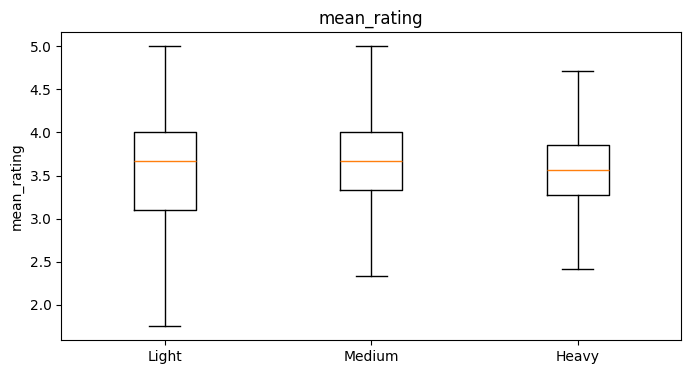

/tmp/ipython-input-3166537964.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Light","Medium","Heavy"], showfliers=False)


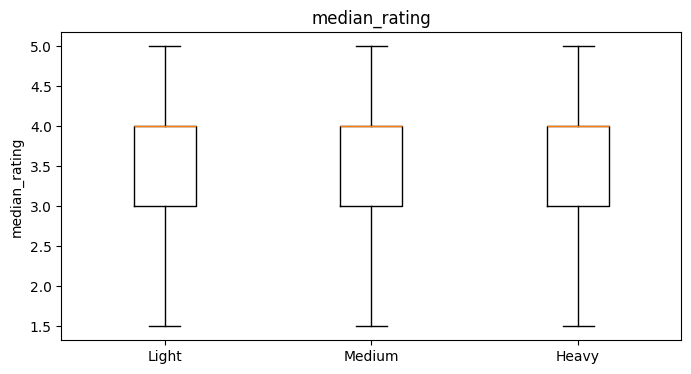

/tmp/ipython-input-3166537964.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Light","Medium","Heavy"], showfliers=False)


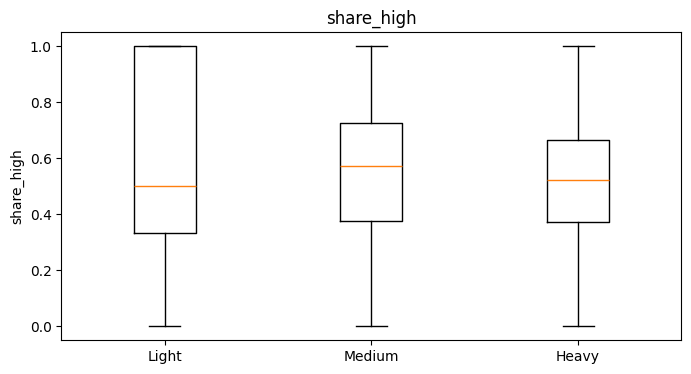

/tmp/ipython-input-3166537964.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Light","Medium","Heavy"], showfliers=False)


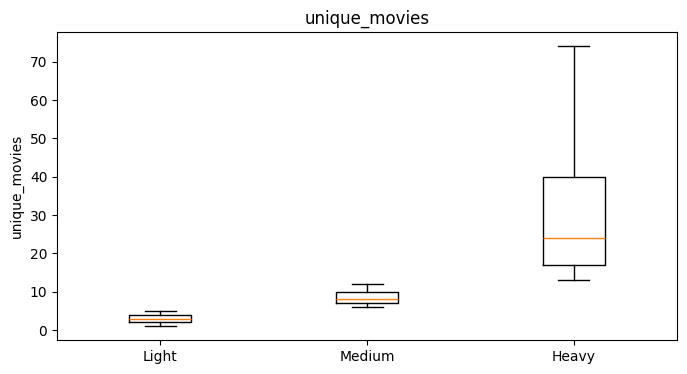

In [26]:
import matplotlib.pyplot as plt

def boxplot_metric(metric):
    data = [user.loc[user["segment"]==s, metric].dropna().to_numpy() for s in ["Light","Medium","Heavy"]]
    plt.figure(figsize=(8,4))
    plt.boxplot(data, labels=["Light","Medium","Heavy"], showfliers=False)
    plt.title(metric)
    plt.ylabel(metric)
    plt.show()

for m in metrics:
    boxplot_metric(m)


**8. Можно ли использовать другие статистические тесты? (примеры)**

Да, например:

1) **Kruskal–Wallis** вместо ANOVA (F-теста), если не хочется предполагать нормальность и сравниваем >=3 независимые группы.  
2) **Permutation test** (пермутационный тест) для разности средних/медиан — не требует параметрических предположений.  
3) **Тесты для долей**: χ² Пирсона или z-тест для двух пропорций — если метрика бинарная на уровне события (например “клик/не клик”).  
4) **Welch ANOVA** — вариант ANOVA, устойчивый к неравенству дисперсий.  
5) **Kolmogorov–Smirnov** — если сравниваем два распределения целиком (а не только сдвиг).
